In [1]:
# import hdf5plugin, h5py
import torch, tables
from torch import nn
import os
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from functools import partial
from tqdm.auto import tqdm
from typing import Any
import torchvision
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
from dataclasses import dataclass
from typing import Callable
import cv2, functools

import torch.nn

In [5]:
# directory = "/storage/uw/3brain/200623_faces/"
# name = "R1_E3_AMES_200min_200f_14l_rgb.h5"
directory = "/storage/uw/3brain/200807_ffhq/"
# name = "R1_E1_AMES_160min_ffhq_0_2501.h5
name = "R1_E4_AMES_640min_ffhq_0_5000.h5"

hdf5 = tables.open_file(os.path.join(directory,name),'r')
h5 = hdf5.root
# h5 = h5py.File(os.path.join(directory,f),'r', swmr=True)

In [6]:
h5["data"][:10].sum()

117195

In [7]:
nExamples, nTime, nRow, nCol, nUnitChannels = h5["data"].shape
h5

/ (RootGroup) ''
  children := ['data' (CArray), 'image_classes' (CArray), 'images' (CArray), 'target' (CArray)]

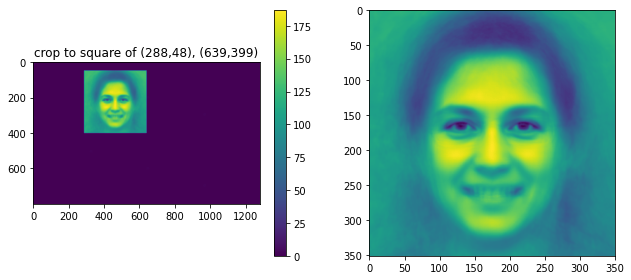

In [8]:
imgs = h5["images"][0:100]

avg_img = np.mean(imgs, axis=(0,3))

y,x = np.where(avg_img>5)

xleft = min(x)
xright = max(x)
ytop = min(y)
ybot = max(y)

plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(avg_img)
plt.colorbar()
plt.title(f"crop to square of ({xleft},{ytop}), ({xright},{ybot})")
plt.subplot(122)
plt.imshow(avg_img[ytop:ybot,xleft:xright])
plt.tight_layout()

In [9]:
def resize_3d(images, fx, fy, interpolation=cv2.INTER_LINEAR, out="ndarray",
        is_tiff=False):
    im = cv2.resize((images[0]), None, fx=fx, fy=fy, interpolation=interpolation)
    if out=="ndarray":
        new = np.zeros([images.shape[0], *im.shape],
            dtype = np.float32)
    elif out=="memmap":
        new = np.memmap("glia_temp_memmap.mmap", np.float32, "w+",
            (images.shape[0], im.shape[0],im.shape[1]))
    for z, img in enumerate(images):
        new[z] = cv2.resize((img), None, fx=fx, fy=fy,
            interpolation=interpolation)
    return new

def gray_3d(images):
    im = cv2.cvtColor(images[0], cv2.COLOR_BGR2GRAY)
    new = np.zeros([images.shape[0], *im.shape],
            dtype = np.float32)
    for z, img in enumerate(images):
        new[z] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return new



@dataclass
class ImageData(Dataset):
    original_images:tables.carray.CArray
#     h5_path:str
#     dset_path:str = "images"
    H:int = 64 # resize to this
    W:int = 64
    convert_to_gray:bool = True
    zero_to_one:bool = True
    interpolation:Callable = cv2.INTER_LINEAR
    crop:Any = None
    
    def __post_init__(self):
        oH, oW = self.original_images.shape[1:3]
        crop = self.crop
        if crop:
            images = self.original_images[:,crop[0]:crop[1],crop[2]:crop[3]]
            oH, oW = images.shape[1:3]
        else:
            images = self.original_images
        self.images = resize_3d(images,
            fx=self.W/oW, fy=self.H/oH, interpolation=self.interpolation)
        if self.convert_to_gray:
            self.images = gray_3d(self.images)[...,None]
        if self.zero_to_one:
            self.images /= 255

        
    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, i):
        im = transforms.functional.to_tensor(self.images[i])
        return im
    
def map_CArray(f, carray, progress=False):
    """Efficient row-wise mapping over tables CArray.
    
    Assumes can fit one row in RAM but not all, and that
    return value of map is smaller such that total result
    fits in RAM."""
    result = []
    gen = range(len(carray))
    if progress:
        gen = tqdm(gen)
    for i in gen:
        result.append(f(carray[i]))
    return result
    
    
@dataclass
class RetinaData(Dataset):
    # we use HDF5 for compression of sparse data
    # otherwise, RAM would blow up. But after binning, not so large
    retina_data:tables.carray.CArray
    nbins:int = 10
        # collapse units into channel
    no_units:bool = False
    def __post_init__(self):
        slices = np.linspace(0, self.retina_data.shape[1], self.nbins+1, True).astype(np.int)
        bin_func = partial(np.add.reduceat, indices=slices[:-1], axis=0, dtype=np.float32)
        binned = np.array(map_CArray(bin_func, self.retina_data, progress=True))
        # CHW
        binned = torch.from_numpy(np.moveaxis(binned,-1,1))
        if self.no_units:
            binned = binned.sum(2, keepdims=True)
        self.data = binned
        
    def __len__(self):
        return self.retina_data.shape[0]
    def __getitem__(self,i):
        return self.data[i]

image_dset = ImageData(h5["images"], crop=[ytop,ybot,xleft,xright])
retina_dset = RetinaData(h5["data"], no_units=True)
(image_dset[0].shape, retina_dset[0].shape)

(torch.Size([1, 64, 64]), torch.Size([6, 1, 64, 64]))

In [10]:
class ConcatDataset(torch.utils.data.Dataset):
    "Combine multiple datasets as tuples."
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)


@dataclass
class ImageRetina(pl.LightningDataModule):
    images_dset:Dataset
    retina_dset:Dataset
    batch_size:int = 64
    # must be single-thread or else BLOSC barfs
    num_workers:int = 8

    def __post_init__(self):
        super().__init__()
        concat_dataset = ConcatDataset(
            self.images_dset, self.retina_dset
        )
        N = len(self.images_dset)
        ntrain = int(N*0.8)
        nval = int(N*0.1)
        ntest = N-ntrain-nval
        lengths = [ntrain, nval, ntest]
        self.train, self.val, self.test = random_split(concat_dataset, lengths,
               generator=torch.Generator().manual_seed(42))
        
    def train_dataloader(self):
        
        loader = torch.utils.data.DataLoader(
            self.train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )
        return loader

    def val_dataloader(self):
        loader = torch.utils.data.DataLoader(
            self.val,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True
        )
        return loader

    def test_dataloader(self):
        loader = torch.utils.data.DataLoader(
            self.test,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True
        )
        return loader



class LocalLinear(nn.Module):
    """Locally connected layer.
    
    https://github.com/pytorch/pytorch/issues/499#issuecomment-538720703
    """
    def __init__(self,in_features,local_features,kernel_size,padding=0,stride=1,bias=True):
        super(LocalLinear, self).__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        fold_num = (in_features+2*padding-self.kernel_size)//self.stride+1
        self.weight = nn.Parameter(torch.randn(fold_num,kernel_size,local_features))
        self.bias = nn.Parameter(torch.randn(fold_num,local_features)) if bias else None

    def forward(self, x:torch.Tensor):
        x = F.pad(x,[self.padding]*2,value=0)
        x = x.unfold(-1,size=self.kernel_size,step=self.stride)
        x = torch.matmul(x.unsqueeze(2),self.weight).squeeze(2)+self.bias
        return x

## VAE

In [11]:
from pathlib import Path
Path("ffhq_viz").mkdir(exist_ok=True)

In [12]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
# Kingma & Welling (2014) style variational autoencoder

# subclass PyTorch Module for reverse-mode autodifferentiation 
# for easy backpropogation of loss gradient
class VAE(pl.LightningModule):
    
    def __init__(self, n_input, H, W, n_hidden, n_latent, n_hidden2, n_output,
                 nonlinearity=F.sigmoid, beta=1, lr = 1e-4, out_folder="ffhq_viz",
                 nrow=8):
        super().__init__()
        self.n_input = n_input
        self.H = H
        self.W = W
        self.beta = beta
        self.n_output = n_output
        self.n_hidden = n_hidden
        self.n_hidden2 = n_hidden2
        self.n_latent = n_latent
        self.nonlinearity = nonlinearity
        self.lr = lr
                
        # Encoder layers
        self.hidden_encoder = nn.Linear(n_input, n_hidden)
        # mean encoding layer 
        self.mean_encoder = nn.Linear(n_hidden, n_latent)
        # log variance encoding layer 
        self.logvar_encoder = nn.Linear(n_hidden, n_latent)
        
        # Decoder layers
        self.hidden_decoder = nn.Linear(n_latent, n_hidden2)
        self.reconstruction_decoder = nn.Linear(n_hidden2, n_output)
        
        # init for logging images
        # make grid of z1 x z2 where z1,z2 \elem (-3.5,-2.5, ..., 3.5)
        self.out_folder = out_folder
        self.nrow = nrow
        self.latents = torch.zeros(self.nrow,self.nrow,n_latent)#.cuda()
        z1_tick = np.linspace(-3.5,3.5,self.nrow,dtype=np.float32)
        z2_tick = np.linspace(-3.5,3.5,self.nrow, dtype=np.float32)
        for i, z1 in enumerate(z1_tick):
            for j, z2 in enumerate(z2_tick):
                self.latents[i,j,[0,1]] = torch.tensor([z1,z2])

    def encode(self, x):
        h1 = self.nonlinearity(self.hidden_encoder(x))
        return self.mean_encoder(h1), self.logvar_encoder(h1)

    def reparameterize(self, mean, logvar):
        """Reparameterize out stochastic node so the gradient can propogate 
           deterministically."""

        if self.training:
            standard_deviation = torch.exp(0.5*logvar)
            # sample from unit gaussian with same shape as standard_deviation
            epsilon = torch.randn_like(standard_deviation)
            return epsilon * standard_deviation + mean
        else:
            return mean

    def decode(self, z):
        h3 = self.nonlinearity(self.hidden_decoder(z))
        # bound output to (0,1)
        return F.sigmoid(self.reconstruction_decoder(h3))

    
    def forward(self, x):
        "A special method in PyTorch modules that is called by __call__"
        mean, logvar = self.encode(x)
        # sample an embedding, z
        z = self.reparameterize(mean, logvar)
        # return the (sampled) reconstruction, mean, and log variance
        return self.decode(z), mean, logvar

    
    def loss_function(self, recon_y, y, mu, logvar):
        "Reconstruction + KL divergence losses summed over all elements and batch."
        BCE = F.binary_cross_entropy(recon_y, y, size_average=False)

        # we want KLD = - 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        # where sigma is standard deviation and mu is mean
        # (see Appendix B of https://arxiv.org/abs/1312.6114)

        # see https://openreview.net/forum?id=Sy2fzU9gl for info on choosing Beta

        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + self.beta * KLD

    def calc_loss(self, batch, batch_idx):
        bz = batch[0].shape[0]
        # flatten batch x height x width x channel into batch x nFeatures
        images = batch[0].reshape(bz, -1)
        retina = batch[1].reshape(bz, -1) # flatten
        images_pred, mu, logvar = self(retina)
        loss = self.loss_function(images_pred, images, mu, logvar)
        return {"loss": loss, "Y": images, "Y_pred": images_pred,
                "X": retina}
        
    def training_step(self, batch, batch_idx):     
        loss_dict = self.calc_loss(batch, batch_idx)
        loss, Y, Y_pred = (loss_dict["loss"], loss_dict["Y"], loss_dict["Y_pred"])
        result = pl.TrainResult(loss)
        result.log('train_loss', loss, prog_bar=True)
        return result
        
    def validation_step(self, batch, batch_idx):
        loss_dict = self.calc_loss(batch, batch_idx)
        loss, Y, Y_pred, X = (loss_dict["loss"], loss_dict["Y"], loss_dict["Y_pred"],
                              loss_dict["X"])
        result = pl.EvalResult(checkpoint_on=loss)
        result.log('val_loss', loss, on_epoch=True)
        
        if batch_idx==0:
            global epoch
            n = min(X.size(0), 15)
            comparison = torch.cat([Y[:n].view(-1,1,self.H,self.W),
                               Y_pred[:n].view(-1,1,self.H,self.W)])
            torchvision.utils.save_image(comparison,
                     self.out_folder+f'/{name}_reconstruction_' + str(epoch) + '.png', nrow=n)
            latent = self.latents.view(-1,self.n_latent).to(X.device)
            latent_space = self.decode(latent)
            ls = latent_space.view(-1, 1, self.H, self.W)
            torchvision.utils.save_image(ls,
                       self.out_folder+'/sample_' + str(epoch) + '.png',nrow=self.nrow)
            epoch += 1
        return result

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
n_input = np.prod(retina_dset[0].shape)
n_hidden = 1000
n_latent = 2
n_hidden2 = 1000
beta = 100
lr = 8e-6
nrow = 8
nonlinearity = F.celu
nonlinearity = torch.sigmoid
n_output = np.prod(image_dset[0].shape)
H, W = image_dset[0].shape[1:]

epoch = 0

!mkdir -p ffhq_viz && rm -rf ffhq_viz/*
dm = ImageRetina(image_dset, retina_dset,batch_size=64)
model = VAE(n_input, H, W, n_hidden, n_latent, n_hidden2, n_output,
            nonlinearity=nonlinearity, lr=8e-4, nrow=nrow)
trainer = pl.Trainer(gpus=[1], gradient_clip_val=0.5)
# trainer = pl.Trainer(num_processes=1, gradient_clip_val=0.5)
trainer.fit(model, dm)
trainer.test(datamodule=dm)

# Retina AE

In [ ]:
# not yet complete
# this is just a plain nn.Module with some structure
@dataclass(unsafe_hash=True)
class RetinaAutoEncoder(pl.LightningModule):
    "Given image, output both retina firing rates + reconstruction"
    imageChannels:int = 3
    nUnitChannels:int = nUnitChannels
    meaH:int = 64
    meaW:int = 64
    # joint hyperparam with data preprocessing (eg binning)
    nTimeSteps:int = 10
    # hyperparams
    conv1_out:int = 8
    conv2_out:int = 8
#     nCelltypes:int = 8
    dconv1_out:int = 8
    dconv2_out:int = 8
    kernel1:int = 15
    kernel2:int = 15
    kernel3:int = 15
    recon_lambda:float = 1
    lr:float = 1e-3
    nonlinearity:Callable = F.relu
        
    def __post_init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=self.imageChannels,
            out_channels=self.conv1_out, kernel_size=self.kernel1,
            padding=self.kernel1//2)
        self.conv2 = nn.Conv2d(in_channels=self.conv1_out,
            out_channels=self.conv2_out, kernel_size=self.kernel2,
            padding=self.kernel2//2)
        c = self.nUnitChannels * self.nTimeSteps # add time dimension
        # output of conv3 is good place to interpret cell types
        self.conv3 = nn.Conv2d(in_channels=self.conv2_out,
            out_channels=c,kernel_size=self.kernel3,
            padding=self.kernel3//2)
        
        # TODO: loss of 1 - l2 norm on weights to encourage winner-takes-all
#         self.celltype = LocalLinear(c)

        self.dconv1 = nn.Conv2d(in_channels=c,out_channels=self.dconv1_out,
                                kernel_size=self.kernel1,
                                padding=self.kernel1//2)
        self.dconv2 = nn.Conv2d(in_channels=self.dconv1_out,
            out_channels=self.dconv2_out, kernel_size=self.kernel2,
            padding=self.kernel2//2)
        # back to RGB
        self.dconv3 = nn.Conv2d(in_channels=self.dconv2_out,
            out_channels=self.imageChannels, kernel_size=self.kernel3,
            padding=self.kernel3//2)
        
        for l in [self.conv1, self.conv2, self.conv3, self.dconv1, self.dconv2, self.dconv3]:
            nn.init.kaiming_normal_(l.weight)
#         self.save_hyperparameters()
        
    def encode(self,x):
        "Image -> Retina response"
        x = self.nonlinearity(self.conv1(x))
        x = self.nonlinearity(self.conv2(x))
        x = self.nonlinearity(self.conv3(x))
        # reshape to Batch x Time x Units x MEA Row x MEA Col
        return x.reshape(-1,self.nTimeSteps,self.nUnitChannels,self.meaH,self.meaW)
    
    def decode(self,x):
        "Retina -> Image response"
        x = x.reshape(-1, self.nTimeSteps*self.nUnitChannels, self.meaH, self.meaW)
        x = self.nonlinearity(self.dconv1(x))
        x = self.nonlinearity(self.dconv2(x))
        x = self.nonlinearity(self.dconv3(x))
        return x
        
    def forward(self, x):
        retina_pred = self.encode(x)
        reconstruction = self.decode(retina_pred)
        return {"retina": retina_pred, "reconstruction": reconstruction}
    
    def calc_loss(self, batch, batch_idx):
        images, retina = batch
        out = self(images)
        # TODO remove this line after debugging why reconstruction loss goes to nan...
        print(f'{out["reconstruction"].mean()=}, {retina.mean()=}, {images.mean()=}')
        recon_loss = F.mse_loss(out["reconstruction"], images, reduction='mean')
        retina_loss = F.poisson_nll_loss(out["retina"], retina, reduction='mean')
        loss = self.recon_lambda * recon_loss + retina_loss
        return loss, recon_loss, retina_loss

    def training_step(self, batch, batch_idx):
        loss, recon_loss, retina_loss = self.calc_loss(batch, batch_idx)
        result = pl.TrainResult(loss)
        result.log('train_loss', loss, prog_bar=True)
        result.log('reconstruction_loss', recon_loss, prog_bar=True)
        result.log('retina_loss', retina_loss, prog_bar=True)
        return result
        
    def validation_step(self, batch, batch_idx):
        loss, recon_loss, retina_loss = self.calc_loss(batch, batch_idx)
        result = pl.EvalResult(checkpoint_on=loss)
        result.log('val_loss', loss, on_epoch=True)
        result.log('val_reconstruction_loss', recon_loss, on_epoch=True)
        result.log('val_retina_loss', retina_loss, on_epoch=True)
        return result

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    

dm = ImageRetina(image_dset, retina_dset,batch_size=32)
model = RetinaAutoEncoder(imageChannels=1, lr=1e-8)
trainer = pl.Trainer(gpus=[1], gradient_clip_val=0.5)
trainer.fit(model, dm)
trainer.test(datamodule=dm)